The purpose of this project is to get some hands-on experience implementing nonparametric algorithms to perform classification and regression. Specifically, we will be implementing a 𝑘-nearest neighbor classifier and regressor. Dataset “Breast Cancer,” a dataset from the UCI Machine Learning repository, for use in classification tasks.

In [1]:
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

sns.set(style="whitegrid")

In [2]:
THEME = "SteelBlue"

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv("Data//breast-cancer-wisconsin.data",header=None)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [6]:
df.columns = ["Sample code number","Clump Thickness","Uniformity of Cell Size","Uniformity of Cell Shape",
              "Marginal Adhesion","Single Epithelial Cell Size","Bare Nuclei","Bland Chromatin","Normal Nucleoli",
              "Mitoses","Class"]

In [7]:
df

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


We see that teh Bare Nuclei attribute has missing values. Let's remove the observations with missing values

In [8]:
df = df[df["Bare Nuclei"] != "?"]

In [9]:
df["Bare Nuclei"] = pd.to_numeric(df["Bare Nuclei"])

C:\Users\Asish_Pradhan\AppData\Local\Temp\ipykernel_19552\780272114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Bare Nuclei"] = pd.to_numeric(df["Bare Nuclei"])


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


<p style="text-align: justify; margin-right:50px">
<strong>Explanation:</strong> We know <strong>Causal Loop Diagrams</strong> are helpful as they are a formal way of specifying a qualitative model in order to refine and share our and stakeholders’ understanding of the system or process under investigation. Therefore with the given dataset a good place to start for us is with a Causal Loop Diagram of at least the known knowns i.e. the data we have. We will try to <strong>elaborate the causal loop diagram</strong> below.
</p>

Based on our understanding on the data we assume we will have below relationship in our data.

1. Clump Thickness $\rightarrow$ Class: The more the clump thickness more chances of having cancer.
2. Uniformity of Cell Size $\rightarrow$ Class: The more uniform the cell size, the less chances of having cancer.
3. Uniformity of Cell Shape $\rightarrow$ Class: The more uniform the cell shape, the less chances of having cancer.
4. Marginal Adhesion $\rightarrow$ Class:  Loss of marginal adhesion is a sign of having cancer.
5. Single Epithelial Cell Size $\rightarrow$ Class: The more the single epithelial cell size the more chances of having cancer.
6. Bare Nuclei $\rightarrow$ Class:  In general, the higher the nuclear grade, the more abnormal the nuclei are and the more aggressive the tumor cells tend to be. Therefore the higher the nuclear grade more chances of having cancer.
7. Bland Chromatin $\rightarrow$ Class: The more the bland chromatin the more chances of having cancer.
8. Normal Nucleoli $\rightarrow$ Class: The more the normal nucleoli the more chances of having cancer.
9. Mitoses $\rightarrow$ Class: The more the mitosis, the more prominent the cancer cells are.

Let's explore more in the EDA section below.

In [11]:
df["Class"] = df["Class"].replace({2: 0, 4: 1})

C:\Users\Asish_Pradhan\AppData\Local\Temp\ipykernel_19552\1860745114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Class"] = df["Class"].replace({2: 0, 4: 1})


## 2 <a id="step2">(EDA) Exploratory Data Analysis</a>
[^ Contents](#contents)

In [12]:
def get_additional_descriptive_statistics(stats):
    result = []
    stat_range = tuple(["Range", stats.loc[["max"]].values[0] - stats.loc[["min"]].values[0]])
    IQR = tuple(["IQR",stats.loc[["75%"]].values[0] - stats.loc[["25%"]].values[0]])
    COV = tuple(["COV",stats.loc[["std"]].values[0]/stats.loc[["mean"]].values[0]])
    
    result.append(stat_range)
    result.append(IQR)    
    result.append(COV)    

    return result

In [13]:
def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)

    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)

    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.2)

    for box in patch["boxes"]:
        box.set( facecolor='#FFFFFF', alpha=0.5)

In [14]:
def get_correlation(data, x, y):
    result = []
    r = tuple(["r", stats.pearsonr(data[x], data[y])[0]])
    rho = tuple(["rho",stats.spearmanr(data[x], data[y])[0]])
   
    result.append(r)
    result.append(rho) 
    
    print('Correlation Cofficients')
    return result

In [15]:
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    restyle_boxplot( patch)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))

    plt.show()
    plt.close()

In [16]:
def describe_by_category(data, numeric, categorical):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    return grouped_y

<a id="singleEDA"></a> 
## Single Variable EDA
[^ Contents](#contents)<br/><br/>
We'll start our EDA by looking at each variable individually, starting with the target variable, *Class*.

* [Class](#Class)
* [Clump Thickness](#ClumpThickness)
* [Uniformity of Cell Size](#UniformityofCellSize)
* [Uniformity of Cell Shape](#UniformityofCellShape)
* [Marginal Adhesion](#MarginalAdhesion)
* [Single Epithelial Cell Size](#SingleEpithelialCellSize)
* [Bare Nuclei](#BareNuclei)
* [Bland Chromatin](#BlandChromatin)
* [Normal Nucleoli](#NormalNucleoli)
* [Mitoses](#Mitoses)

<a id="Class"></a> 
## Class

Class is a categorical variable with values 1 and 0. 1 represents cancer and 0 denotes no cancer.

In [17]:
df_counts = pd.DataFrame(df["Class"].value_counts().sort_index())
df_counts

,Class
0,444
1,239


We see more benign (negative for breast cancer) compared to maligant (positive for breast cancer). Let's see how these shows up in percentages.

In [18]:
df_counts = pd.DataFrame(df["Class"].value_counts(normalize=True).sort_index())
df_counts

,Class
0,0.650073
1,0.349927


Presense of benign data are 65%, and maligant is 35%. Let's visualize this in a bar plot.

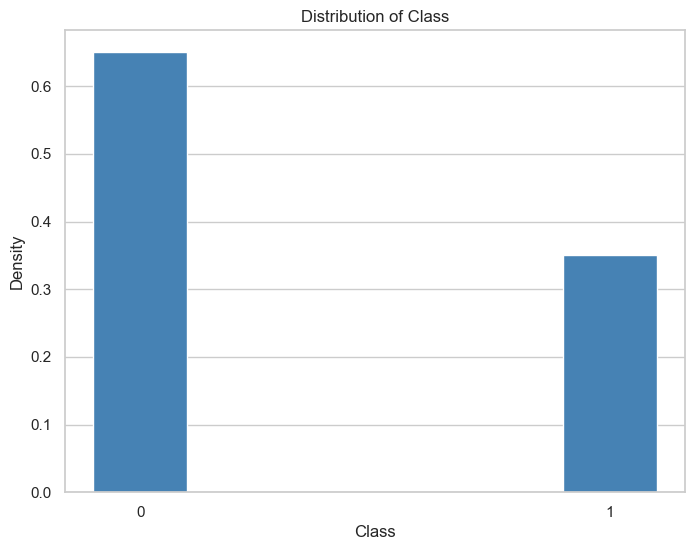

In [19]:
counts = df["Class"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/5
figure = plt.figure(figsize=(8, 6))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color=THEME, align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Distribution of Class")
axes.set_xlabel("Class")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)
plt.show()
plt.close()

<a id="ClumpThickness"></a> 
## Clump Thickness

Clump thickness is a numerical continious variable.

In [20]:
ds = df["Clump Thickness"].describe()
pd.DataFrame(ds)

,Clump Thickness
count,683.000000
mean,4.442167
std,2.820761
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,10.000000


The minimum and the maximum clump thickness are 1 and 10 respectively. We see that the mean clump thickness is 4.44 and the median clump thickness is 4. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [21]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,4.0000
COV,0.6350


The range is 9 i.e. the difference between the max and min values. The interquartile range is 4 and the coefficient of variance (standard deviation over mean in percentage) is 63.5%. Lets start with the box plot to visualize the above descriptive statistics.

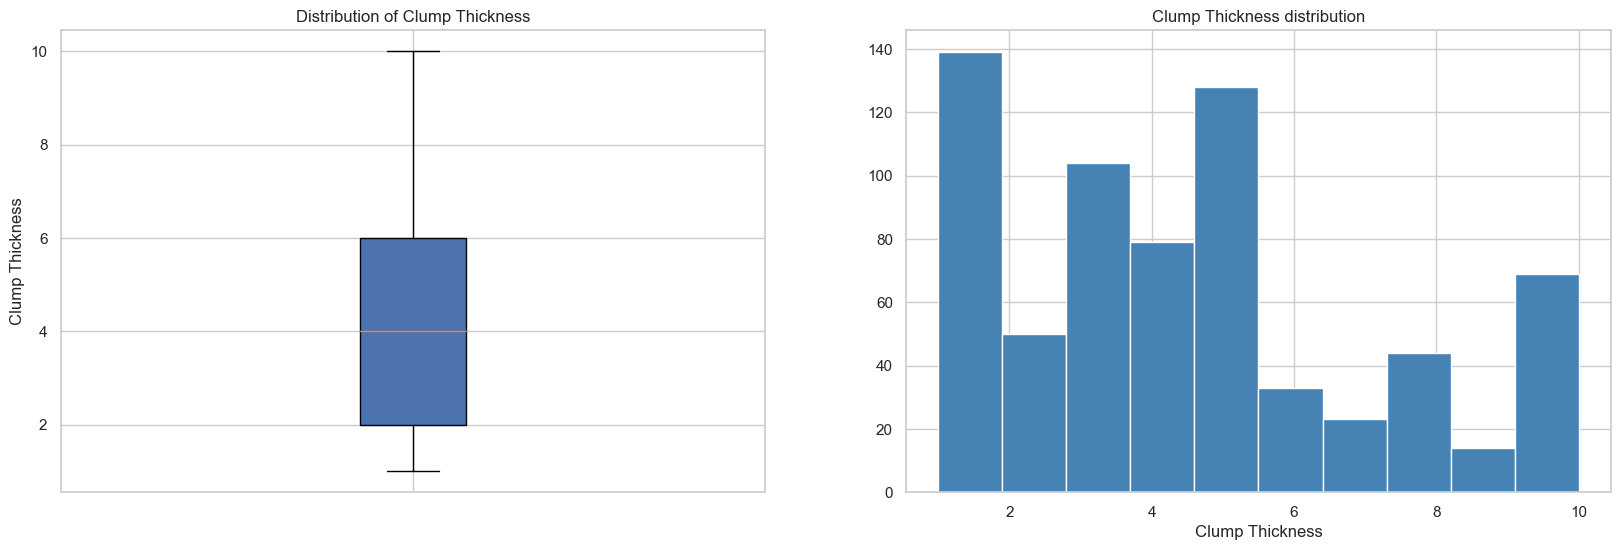

In [22]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Clump Thickness"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
#restyle_boxplot(patch)
axes.set_title("Distribution of Clump Thickness")
axes.set_ylabel("Clump Thickness")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Clump Thickness"],bins=10, color=THEME)
axes.set_title("Clump Thickness distribution")
axes.set_xlabel("Clump Thickness")

plt.show()
plt.close()

Above mentioned descritive dtatistics are represented in the box plot. The histogram above appears to be right skewed bell shaped with more data between 1 to 5 approximately.

<a id="UniformityofCellSize"></a> 
## Uniformity of Cell Size

Uniformity of Cell Size is a numerical continious variable.

In [23]:
ds = df["Uniformity of Cell Size"].describe()
pd.DataFrame(ds)

,Uniformity of Cell Size
count,683.000000
mean,3.150805
std,3.065145
min,1.000000
25%,1.000000
50%,1.000000
75%,5.000000
max,10.000000


The minimum and the maximum uniformity of cell size are 1 and 10 respectively. We see that the mean uniformity of cell size is 3.15 and the median uniformity of cell size is 4. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [24]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,4.0000
COV,0.9728


The range is 9 i.e. the difference between the max and min values. The interquartile range is 4 and the coefficient of variance (standard deviation over mean in percentage) is 97.28%. Lets start with the box plot to visualize the above descriptive statistics.

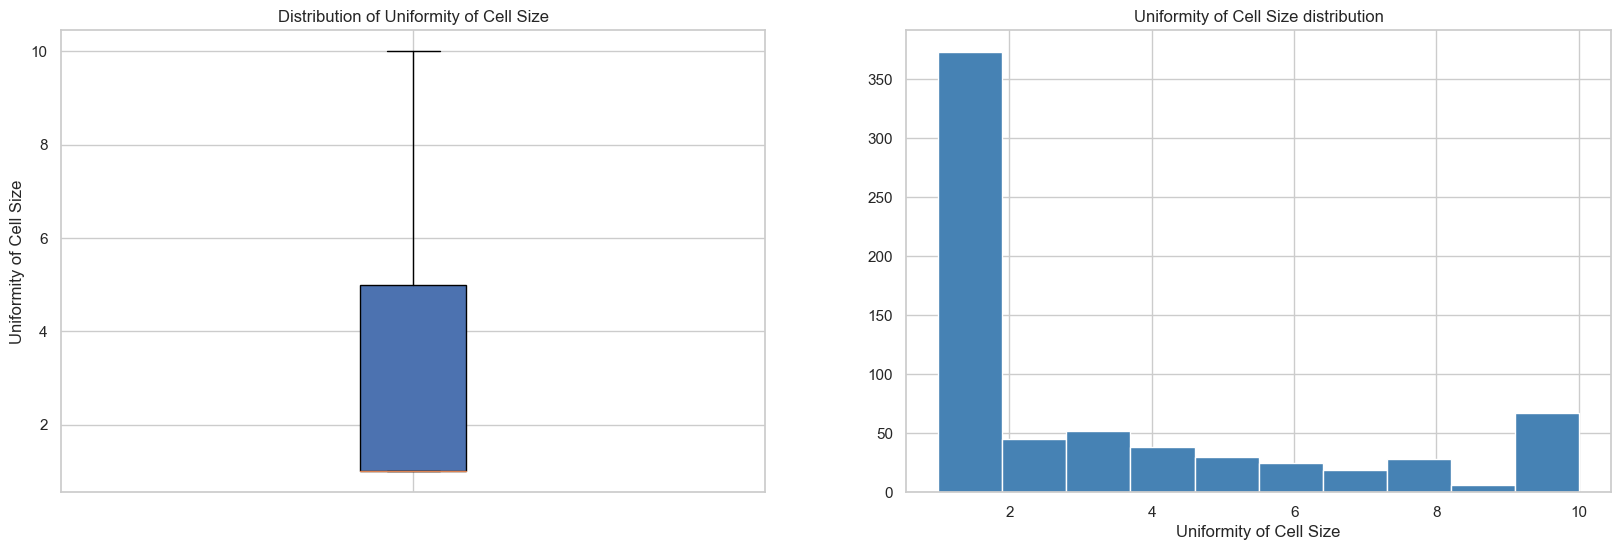

In [25]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Uniformity of Cell Size"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
axes.set_title("Distribution of Uniformity of Cell Size")
axes.set_ylabel("Uniformity of Cell Size")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Uniformity of Cell Size"],bins=10, color=THEME)
axes.set_title("Uniformity of Cell Size distribution")
axes.set_xlabel("Uniformity of Cell Size")

plt.show()
plt.close()

Above mentioned descritive dtatistics are represented in the box plot. The histogram above appears to be right skewed bell shaped with a lot of data at 1.

<a id="UniformityofCellShape"></a> 
## Uniformity of Cell Shape

Uniformity of Cell Shape is a numerical continious variable.

In [26]:
ds = df["Uniformity of Cell Shape"].describe()
pd.DataFrame(ds)

,Uniformity of Cell Shape
count,683.000000
mean,3.215227
std,2.988581
min,1.000000
25%,1.000000
50%,1.000000
75%,5.000000
max,10.000000


The minimum and the maximum clump thickness are 1 and 10 respectively. We see that the mean uniformity of cell shape is 3.21 and the median uniformity of cell shape is 1. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [27]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,4.0000
COV,0.9295


The range is 9 i.e. the difference between the max and min values. The interquartile range is 4 and the coefficient of variance (standard deviation over mean in percentage) is 92.95%. Lets start with the box plot to visualize the above descriptive statistics.

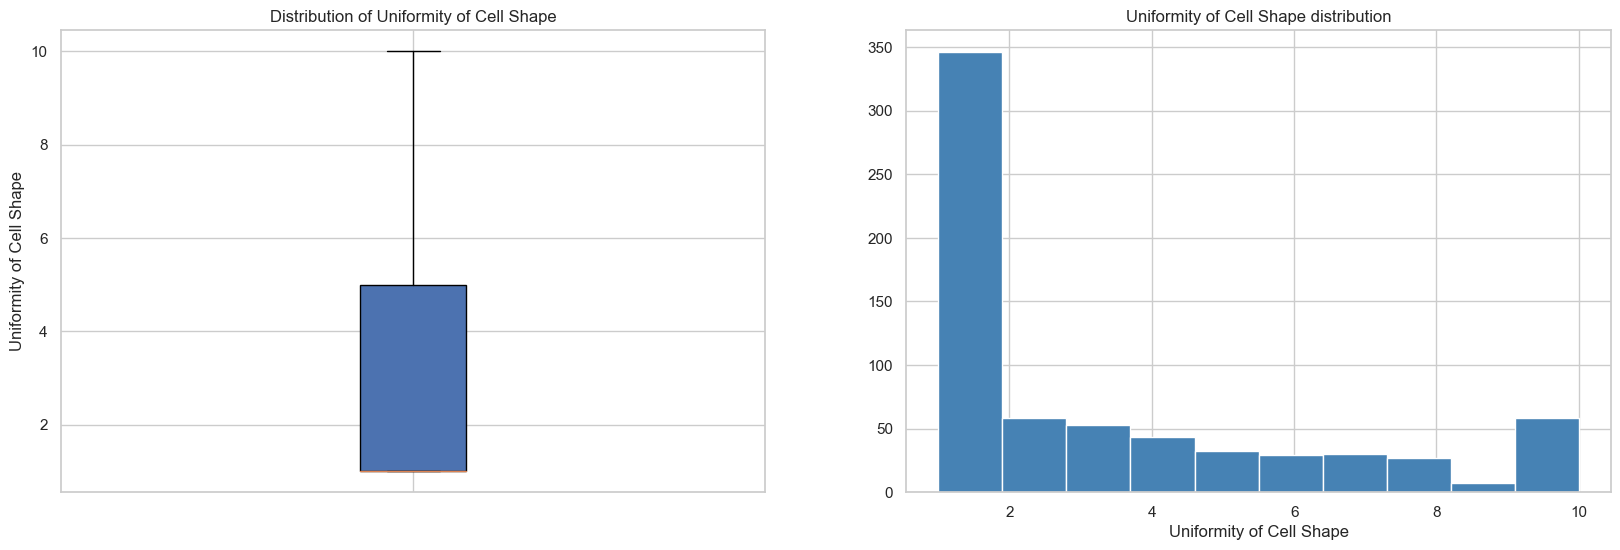

In [28]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Uniformity of Cell Shape"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
#restyle_boxplot(patch)
axes.set_title("Distribution of Uniformity of Cell Shape")
axes.set_ylabel("Uniformity of Cell Shape")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Uniformity of Cell Shape"],bins=10, color=THEME)
axes.set_title("Uniformity of Cell Shape distribution")
axes.set_xlabel("Uniformity of Cell Shape")

plt.show()
plt.close()

Above mentioned descritive dtatistics are represented in the box plot. The histogram above appears to be right skewed with a lot of data at 1.

<a id="MarginalAdhesion"></a> 
## Marginal Adhesion

Marginal adhesion is a numerical continious variable.

In [29]:
ds = df["Marginal Adhesion"].describe()
pd.DataFrame(ds)

,Marginal Adhesion
count,683.000000
mean,2.830161
std,2.864562
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,10.000000


The minimum and the maximum clump thickness are 1 and 10 respectively. We see that the mean marginal adhesion is 2.83 and the median marginal adhesion is 1. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [30]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,3.0000
COV,1.0122


The range is 9 i.e. the difference between the max and min values. The interquartile range is 4 and the coefficient of variance (standard deviation over mean in percentage) is 100%. Let's start with the box plot to visualize the above descriptive statistics.

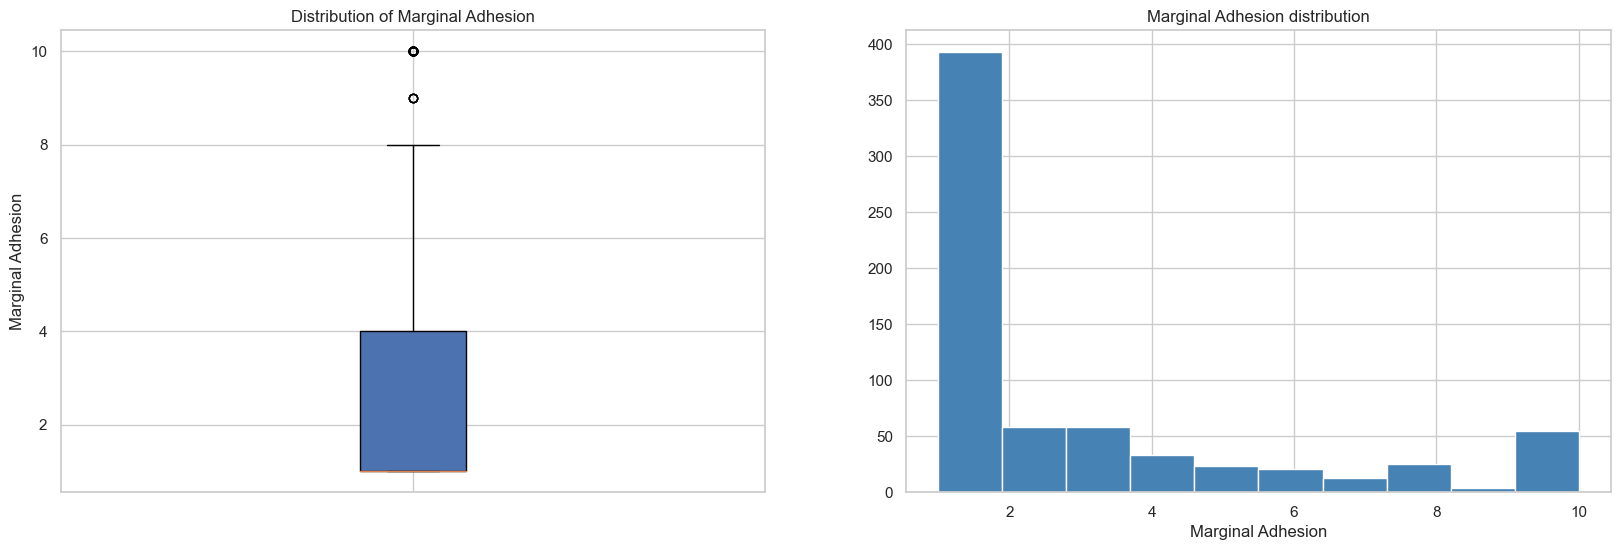

In [31]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Marginal Adhesion"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
#restyle_boxplot(patch)
axes.set_title("Distribution of Marginal Adhesion")
axes.set_ylabel("Marginal Adhesion")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Marginal Adhesion"],bins=10, color=THEME)
axes.set_title("Marginal Adhesion distribution")
axes.set_xlabel("Marginal Adhesion")

plt.show()
plt.close()

Above mentioned descriptive statistics are represented in the box plot. There appears to be a couple of outliers. However we can't just ignore these as we don't know the impact of these outliers just yet. The histogram above appears to be right skewed with more data between 1 to 2 approximately.

<a id="SingleEpithelialCellSize"></a> 
## Single Epithelial Cell Size

Single Epithelial Cell Size is a numerical continious variable.

In [32]:
ds = df["Single Epithelial Cell Size"].describe()
pd.DataFrame(ds)

,Single Epithelial Cell Size
count,683.000000
mean,3.234261
std,2.223085
min,1.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,10.000000


The minimum and the maximum clump thickness are 1 and 10 respectively. We see that the mean Single epithelial cell size is 3.23 and the median marginal adhesion is 2. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [33]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,2.0000
COV,0.6874


The range is 9 i.e. the difference between the max and min values. The interquartile range is 2 and the coefficient of variance (standard deviation over mean in percentage) is 68.74%. Lets start with the box plot to visualize the above descriptive statistics.

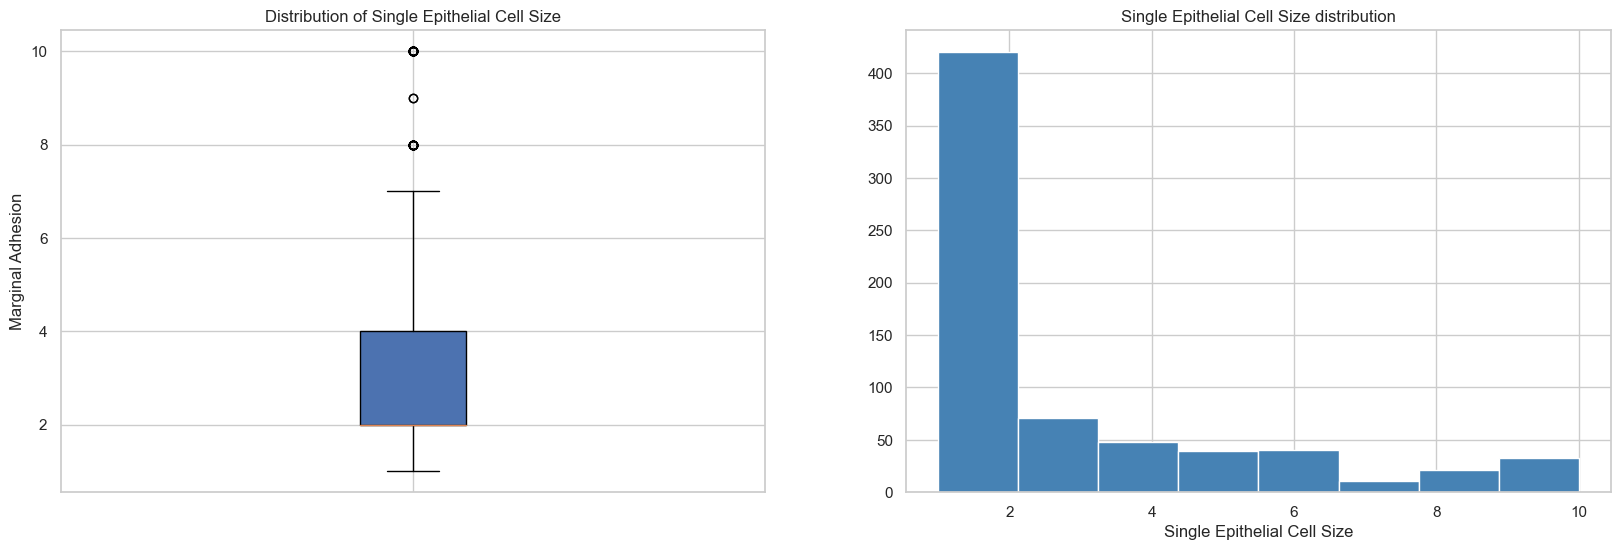

In [34]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Single Epithelial Cell Size"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
#restyle_boxplot(patch)
axes.set_title("Distribution of Single Epithelial Cell Size")
axes.set_ylabel("Marginal Adhesion")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Single Epithelial Cell Size"],bins=8, color=THEME)
axes.set_title("Single Epithelial Cell Size distribution")
axes.set_xlabel("Single Epithelial Cell Size")

plt.show()
plt.close()

Above mentioned descriptive statistics are represented in the box plot. There appears to be a 3 outliers after 8. However we can't just ignore these as we don't know the impact of these outliers just yet. The histogram above appears to be right skewed with more data between 1 to 2 approximately.

<a id="BareNuclei"></a> 
## Bare Nuclei

Bare Nuclei is a numerical continious variable.

In [35]:
ds = df["Bare Nuclei"].describe()
pd.DataFrame(ds)

,Bare Nuclei
count,683.000000
mean,3.544656
std,3.643857
min,1.000000
25%,1.000000
50%,1.000000
75%,6.000000
max,10.000000


The minimum and the maximum clump thickness are 1 and 10 respectively. We see that the mean marginal adhesion is 3.54 and the median marginal adhesion is 1. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [36]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,5.0000
COV,1.0280


The range is 9 i.e. the difference between the max and min values. The interquartile range is 5 and the coefficient of variance (standard deviation over mean in percentage) is 100%. Lets start with the box plot to visualize the above descriptive statistics.

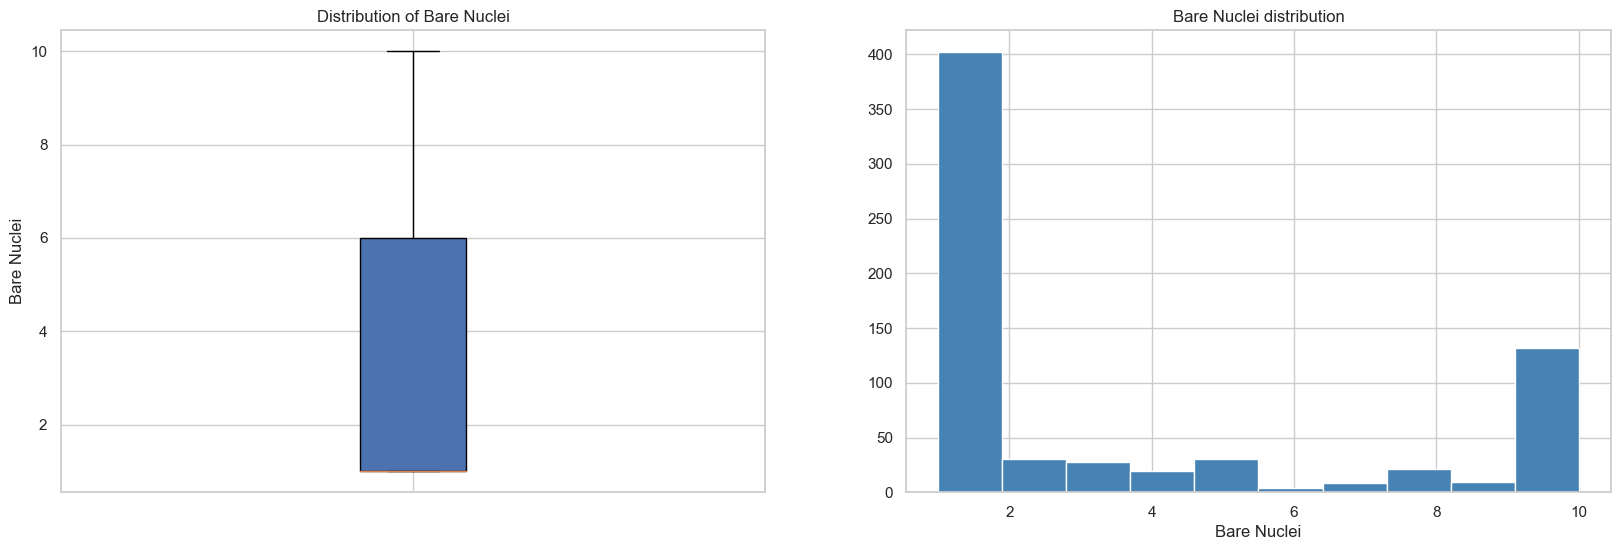

In [37]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Bare Nuclei"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
#restyle_boxplot(patch)
axes.set_title("Distribution of Bare Nuclei")
axes.set_ylabel("Bare Nuclei")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Bare Nuclei"],bins=10, color=THEME)
axes.set_title("Bare Nuclei distribution")
axes.set_xlabel("Bare Nuclei")

plt.show()
plt.close()

Above mentioned descriptive statistics are represented in the box plot. The histogram above appears to be right skewed bell shaped with more data between 1 to 2 approximately. Interestingly we see substantial data between 9 and 10.

<a id="BlandChromatin"></a> 
## Bland Chromatin

Bland Chromatin is a numerical continious variable.

In [38]:
ds = df["Bland Chromatin"].describe()
pd.DataFrame(ds)

,Bland Chromatin
count,683.000000
mean,3.445095
std,2.449697
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,10.000000


The minimum and the maximum clump thickness are 1 and 10 respectively. We see that the mean bland chromatin is 3.44 and the median bland chromatin is 3. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [39]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,3.0000
COV,0.7111


The range is 9 i.e. the difference between the max and min values. The interquartile range is 3 and the coefficient of variance (standard deviation over mean in percentage) is 71.11%. Lets start with the box plot to visualize the above descriptive statistics.

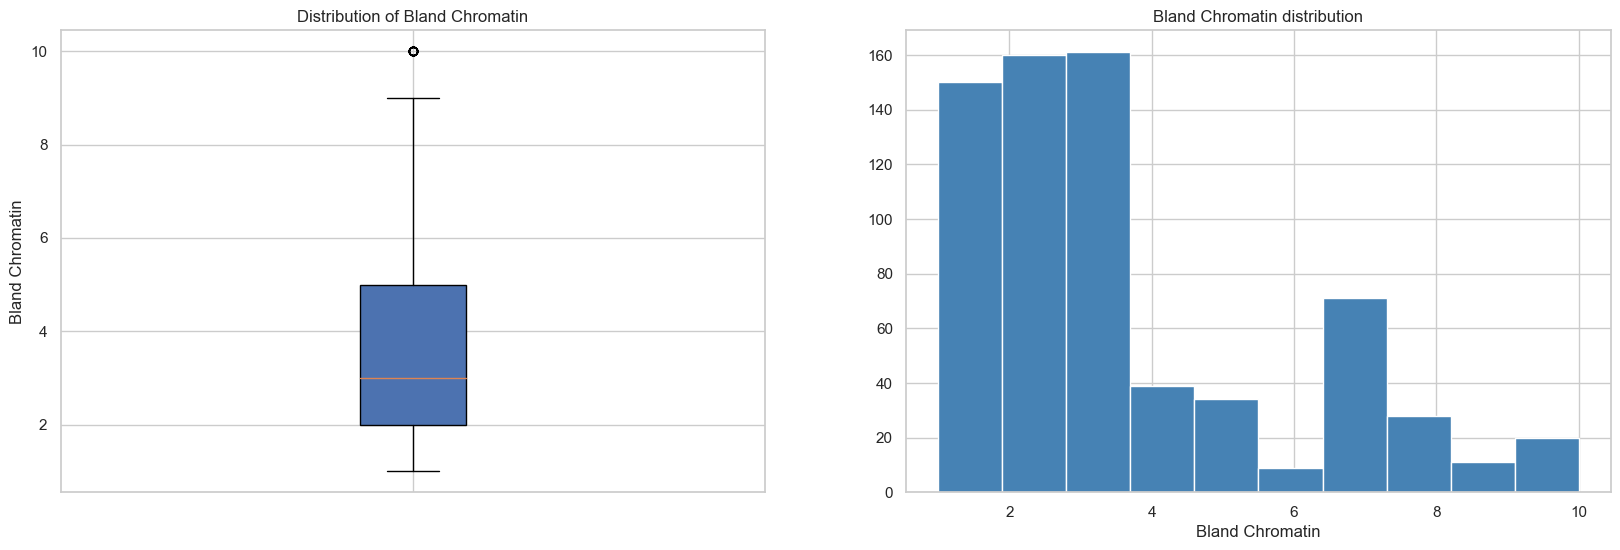

In [40]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Bland Chromatin"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
#restyle_boxplot(patch)
axes.set_title("Distribution of Bland Chromatin")
axes.set_ylabel("Bland Chromatin")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Bland Chromatin"],bins=10, color=THEME)
axes.set_title("Bland Chromatin distribution")
axes.set_xlabel("Bland Chromatin")

plt.show()
plt.close()

Above mentioned descriptive statistics are represented in the box plot. There appears to be a one outlier. However we can't just ignore these as we don't know the impact of these outliers just yet. The histogram above appears to be right skewedwith more data between 1 to 3 approximately.

<a id="NormalNucleoli"></a> 
## Normal Nucleoli

Normal Nucleoli is a numerical continious variable.

In [41]:
ds = df["Normal Nucleoli"].describe()
pd.DataFrame(ds)

,Normal Nucleoli
count,683.000000
mean,2.869693
std,3.052666
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,10.000000


The minimum and the maximum clump thickness are 1 and 10 respectively. We see that the mean normal nucleoli is 2.86 and the median normal nucleoli is 1. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [42]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,3.0000
COV,1.0638


The range is 9 i.e. the difference between the max and min values. The interquartile range is 3 and the coefficient of variance (standard deviation over mean in percentage) is 100%. Lets start with the box plot to visualize the above descriptive statistics.

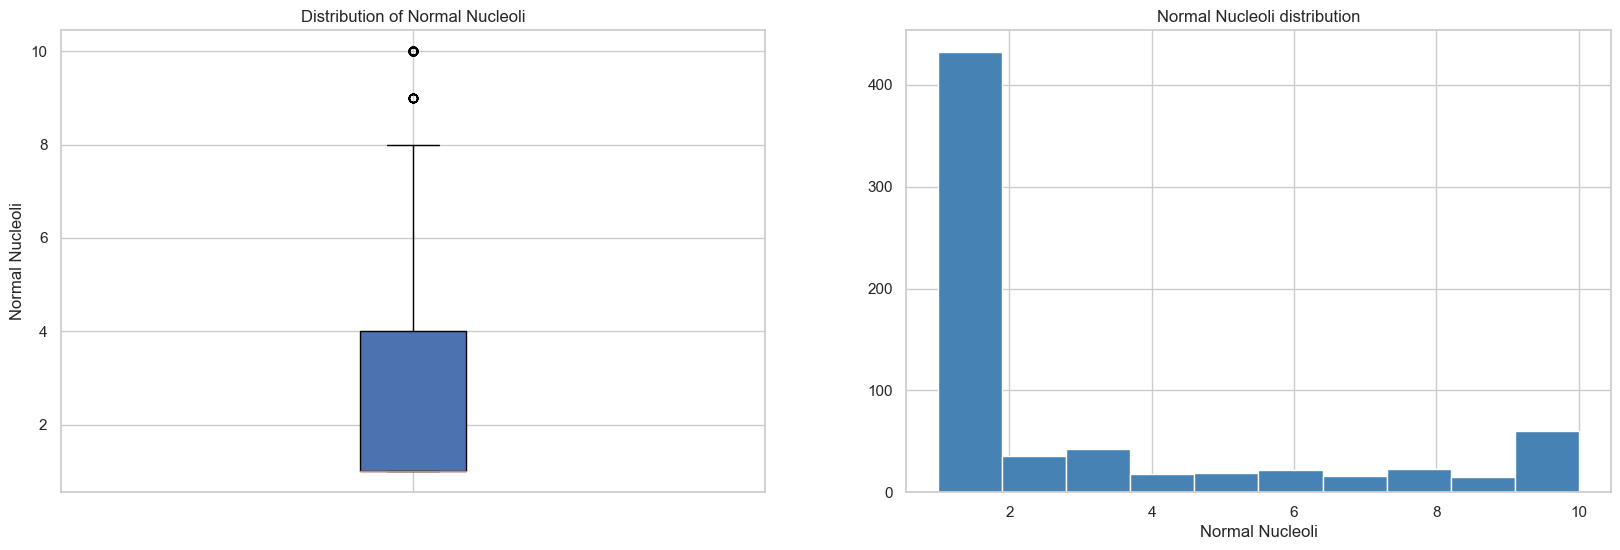

In [43]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Normal Nucleoli"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
#restyle_boxplot(patch)
axes.set_title("Distribution of Normal Nucleoli")
axes.set_ylabel("Normal Nucleoli")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Normal Nucleoli"],bins=10, color=THEME)
axes.set_title("Normal Nucleoli distribution")
axes.set_xlabel("Normal Nucleoli")

plt.show()
plt.close()

Above mentioned descriptive statistics are represented in the box plot. There appears to be a couple of outliers. However we can't just ignore these as we don't know the impact of these outliers just yet. The histogram above appears to be right skewed with more data between 1 to 2 approximately.

<a id="Mitoses"></a> 
## Mitoses

Mitoses is a numerical continious variable.

In [44]:
ds = df["Mitoses"].describe()
pd.DataFrame(ds)

,Mitoses
count,683.000000
mean,1.603221
std,1.732674
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,10.000000


The minimum and the maximum clump thickness are 1 and 10 respectively. We see that the mean mitoses is 1.60 and the median mitoses is 1. As the mean is more than the median value we expect to see a right skewness in the data distribution. Let's see some more descriptive statistics of length.

In [45]:
additional_stats = get_additional_descriptive_statistics(ds)
tabulate(additional_stats, headers=["Stats","Values"], tablefmt='html', floatfmt=".4f") 

Stats,Values
Range,9.0000
IQR,0.0000
COV,1.0807


The range is 9 i.e. the difference between the max and min values. The interquartile range is 0 and the coefficient of variance (standard deviation over mean in percentage) is 100%. Lets start with the box plot to visualize the above descriptive statistics.

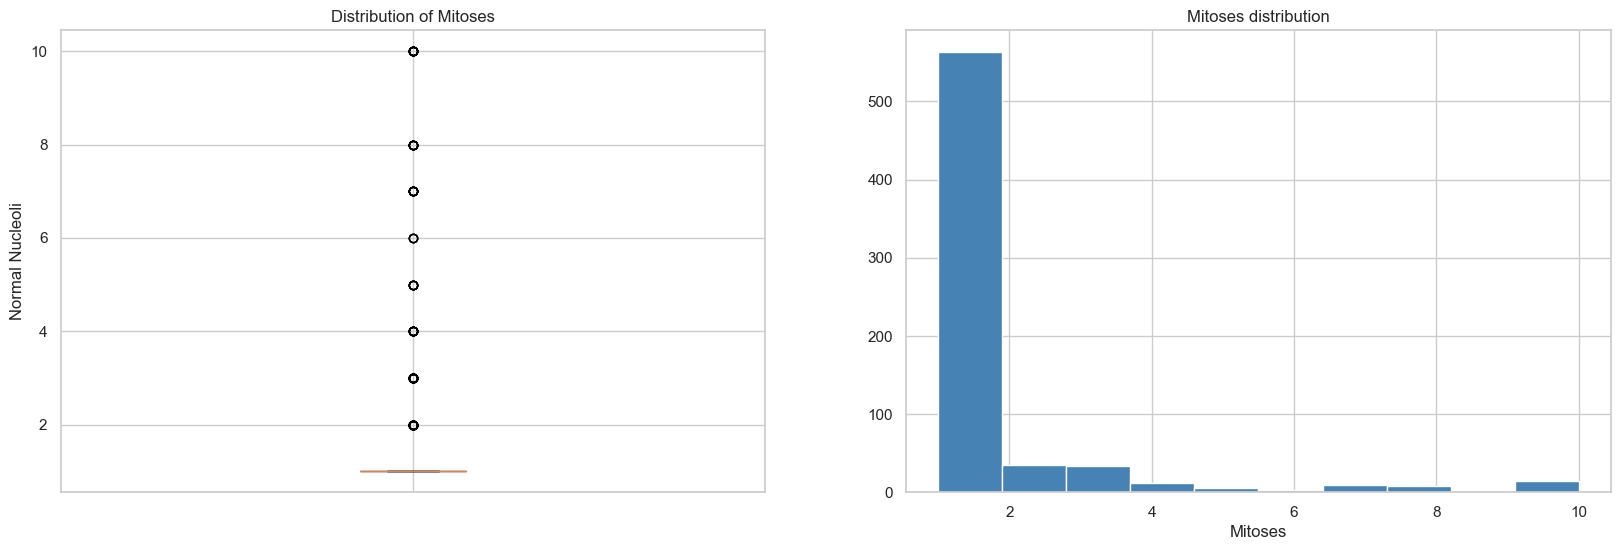

In [46]:
figure = plt.figure(figsize=(20, 6))
axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(df["Mitoses"], labels=[''], showfliers=True, patch_artist=True,zorder=1)
#restyle_boxplot(patch)
axes.set_title("Distribution of Mitoses")
axes.set_ylabel("Normal Nucleoli")

axes = figure.add_subplot(1, 2, 2)
axes.hist(df["Mitoses"],bins=10, color=THEME)
axes.set_title("Mitoses distribution")
axes.set_xlabel("Mitoses")

plt.show()
plt.close()

Above mentioned descriptive statistics are represented in the box plot. The plots apprear to be a bit strange. The data may not be good. There appears to be a lot of outliers. However we can't just ignore these as we don't know the impact of these outliers just yet. The histogram above appears to be right skewed with more data between 1 to 2 approximately.

<a id="pairwiseEDA"></a> 
## Pairwise EDA

## Class v. ?

We will do a pairwise EDA with the target variable.

* [Clump Thickness](#v_ClumpThickness)
* [Uniformity of Cell Size](#v_UniformityofCellSize)
* [Uniformity of Cell Shape](#v_UniformityofCellShape)
* [Marginal Adhesion](#v_MarginalAdhesion)
* [Single Epithelial Cell Size](#v_SingleEpithelialCellSize)
* [Bare Nuclei](#v_BareNuclei)
* [Bland Chromatin](#v_BlandChromatin)
* [Normal Nucleoli](#v_NormalNucleoli)
* [Mitoses](#v_Mitoses)

<a id="v_ClumpThickness"></a>
## Class v. Clump Thickness

In [47]:
ds = describe_by_category(df, "Clump Thickness", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,2.963964,1.672661,1.0,1.0,3.0,4.0,8.0
1,239.0,7.188285,2.437907,1.0,5.0,8.0,10.0,10.0


We see there are 444 benign observations with a mean clump thickness of 2.96 almost same as the median, 239 malignant observations with mean clump thickness of 7.18. In malignant case the mean is less than the median, therefore we sense a left skewness in the data distribution.

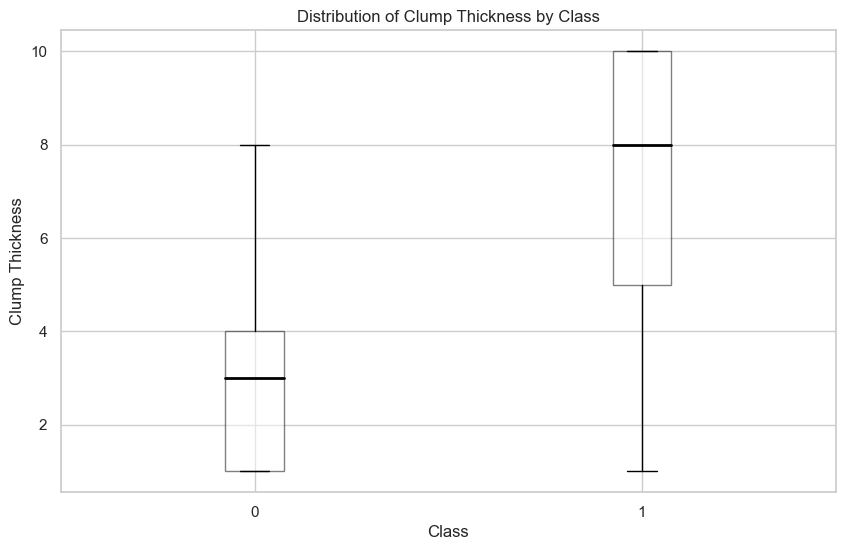

In [48]:
multiboxplot(df, "Clump Thickness", "Class")

Looks like the clump thickness is more in malignant cases. The avergae difference is about 5.

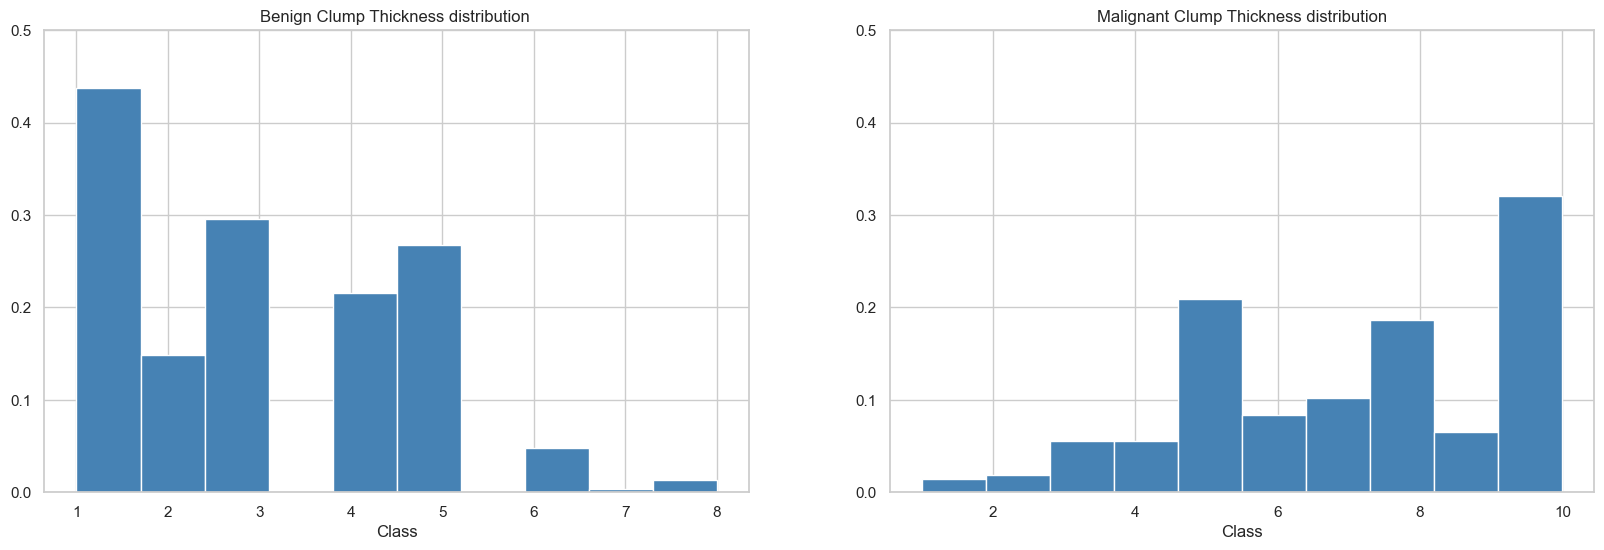

In [49]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Clump Thickness"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Clump Thickness distribution ")
axes.set_xlabel("Class")
axes.set_ylim((0,0.5))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Clump Thickness"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Clump Thickness distribution")
axes.set_xlabel("Class")
axes.set_ylim((0,0.5))

plt.show()
plt.close()

As we hypothesized we see the left skewed data for malignant case. For benign the samples are more around 1 and for malignant its more around 10.

<a id="v_UniformityofCellSize"></a>
## Class v. Uniformity of Cell Size

In [50]:
ds = describe_by_category(df, "Uniformity of Cell Size", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,1.306306,0.855657,1.0,1.0,1.0,1.0,9.0
1,239.0,6.577406,2.724244,1.0,4.0,6.0,10.0,10.0


We see there are 444 benign observations with a mean Uniformity of Cell Size of 1.3, 239 malignant observations with mean Uniformity of Cell Size of 6.57. In both the cases the mean is more than the median, therefore we sense a right skewness in the data distribution.

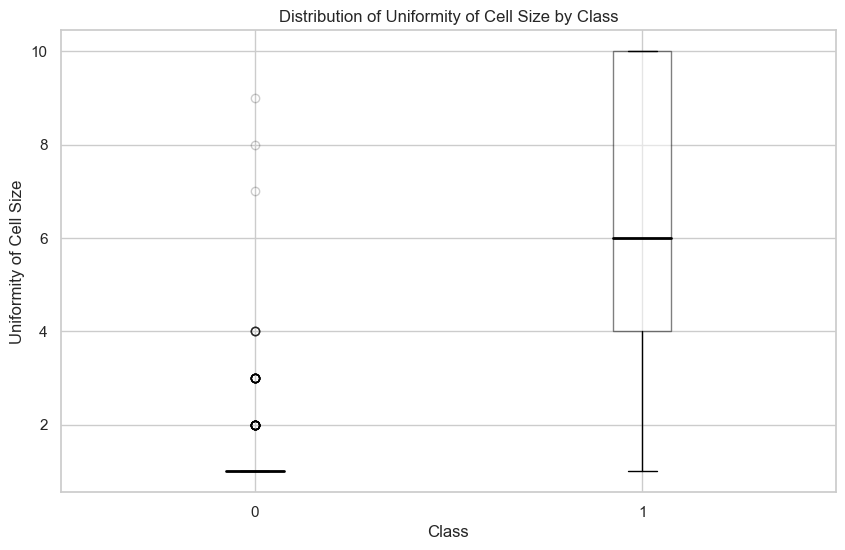

In [51]:
multiboxplot(df, "Uniformity of Cell Size", "Class")

Looks like the Uniformity of Cell Size for benigns is below 1 where as for malignant case its quite large. 

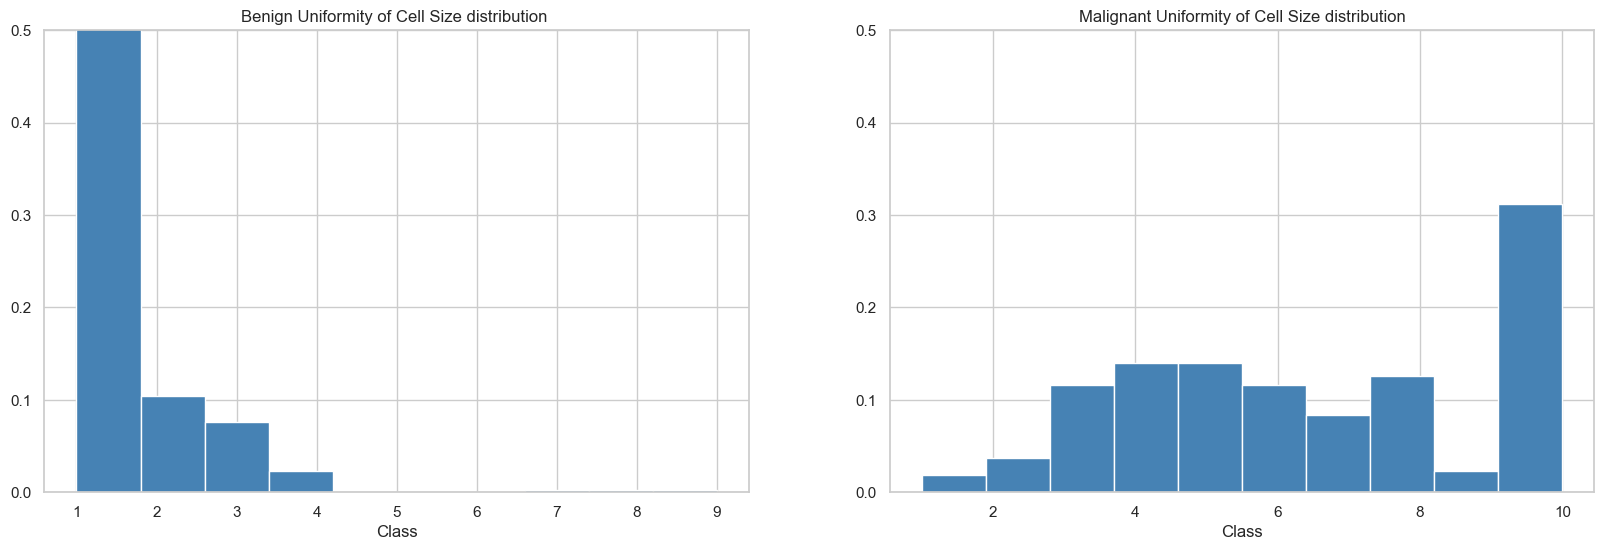

In [52]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Uniformity of Cell Size"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Uniformity of Cell Size distribution ")
axes.set_xlabel("Class")
axes.set_ylim((0,0.5))

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Uniformity of Cell Size"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Uniformity of Cell Size distribution")
axes.set_xlabel("Class")
axes.set_ylim((0,0.5))

plt.show()
plt.close()

As we hypothesized we see the right skewed data for both the cases. For benign the samples are more around 1 and for malignant its more around 10.

<a id="v_UniformityofCellShape"></a>
## Class v. Uniformity of Cell Shape

In [53]:
ds = describe_by_category(df, "Uniformity of Cell Shape", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,1.414414,0.957031,1.0,1.0,1.0,1.0,8.0
1,239.0,6.560669,2.569104,1.0,4.0,6.0,9.0,10.0


We see there are 444 benign observations with a mean Uniformity of Cell Shape of 1.41, 239 malignant observations with mean Uniformity of Cell Shape of 6.56. We see that the samples have smaller Uniformity of Cell Shape in benign cases. Both the cases the mean is more than the median, therefore we sense a right skewness in the data distribution.

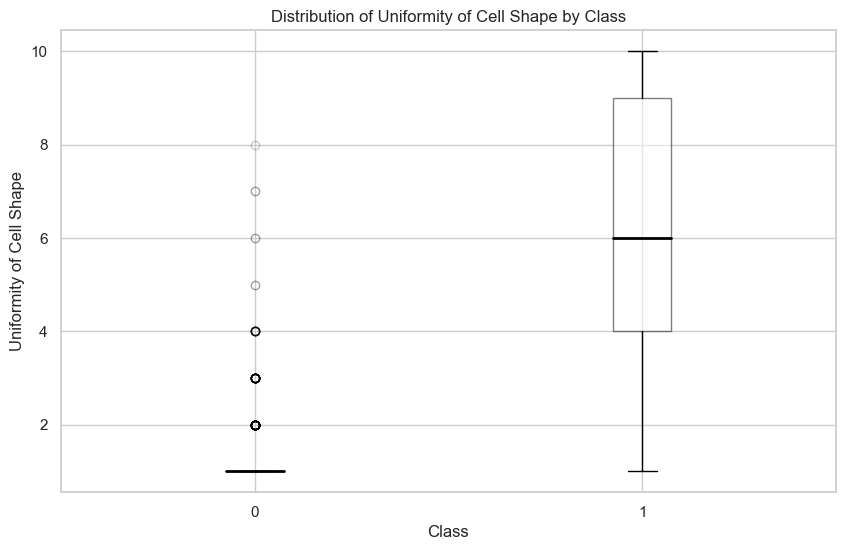

In [54]:
multiboxplot(df, "Uniformity of Cell Shape", "Class")

Looks like the Uniformity of Cell Shape is more in malignant cases. The benign samples have a few outliers.

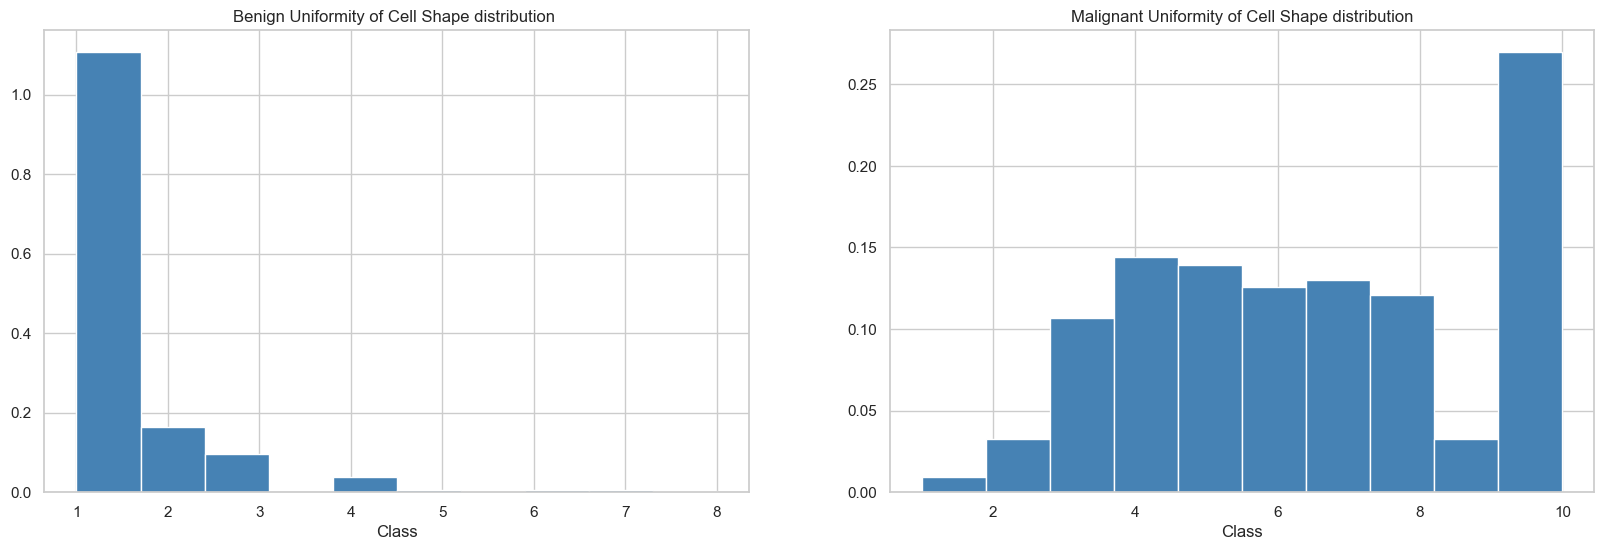

In [55]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Uniformity of Cell Shape"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Uniformity of Cell Shape distribution ")
axes.set_xlabel("Class")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Uniformity of Cell Shape"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Uniformity of Cell Shape distribution")
axes.set_xlabel("Class")

plt.show()
plt.close()

As we hypothesized we see the right skewed data for benign case. Malignant samples appear to be bell shaped with more data around 10.

<a id="v_MarginalAdhesion"></a>
## Class v. Marginal Adhesion

In [56]:
ds = describe_by_category(df, "Marginal Adhesion", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,1.346847,0.917088,1.0,1.0,1.0,1.0,10.0
1,239.0,5.585774,3.196631,1.0,3.0,5.0,8.0,10.0


We see there are 444 benign observations with a mean Marginal Adhesion of 1.34, 239 malignant observations with mean Marginal Adhesion of 5.58. We see that the samples have smaller Marginal Adhesion in benign cases. Both the cases the mean is more than the median, therefore we sense a right skewness in the data distribution.

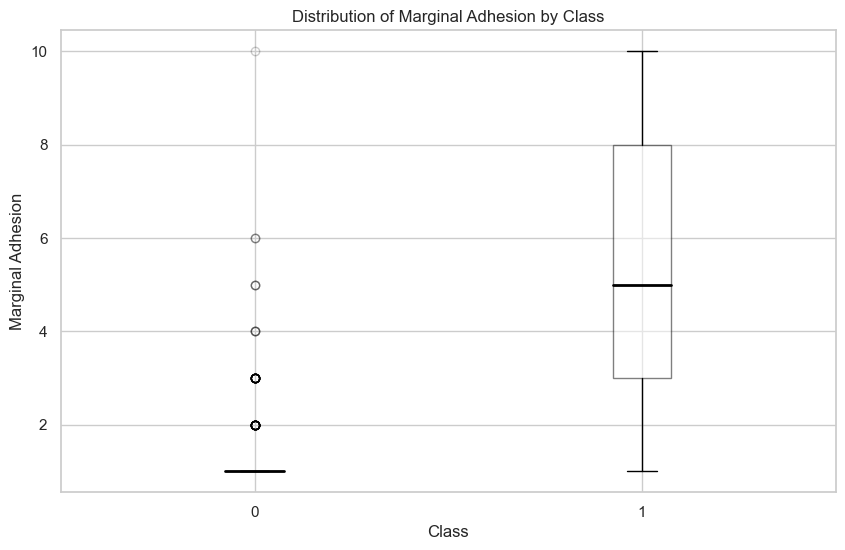

In [57]:
multiboxplot(df, "Marginal Adhesion", "Class")

Looks like the Marginal Adhesion is more in malignant cases. The benign samples have a few outliers.

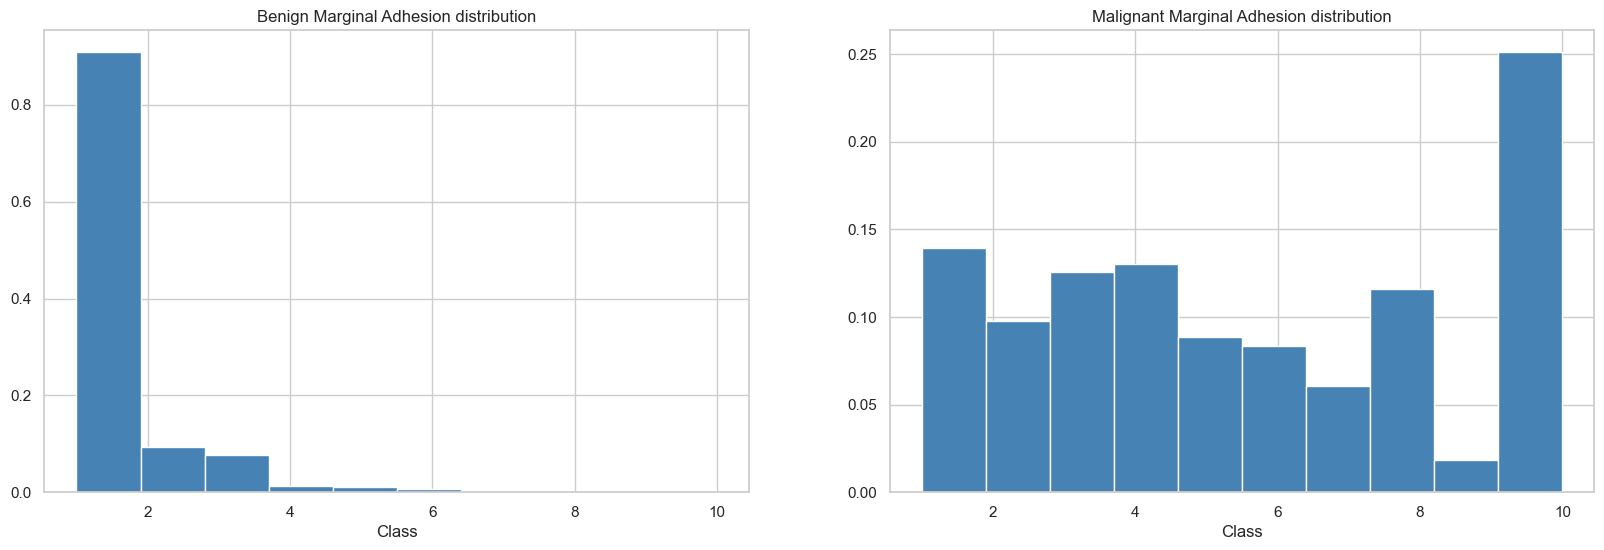

In [58]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Marginal Adhesion"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Marginal Adhesion distribution")
axes.set_xlabel("Class")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Marginal Adhesion"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Marginal Adhesion distribution")
axes.set_xlabel("Class")

plt.show()
plt.close()

As we hypothesized we see the right skewed data for benign case. Malignant samples appear to be bell shaped with more data around 10.

<a id="v_SingleEpithelialCellSize"></a>
## Class v. Single Epithelial Cell Size

In [59]:
ds = describe_by_category(df, "Single Epithelial Cell Size", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,2.108108,0.877112,1.0,2.0,2.0,2.0,10.0
1,239.0,5.326360,2.443087,1.0,3.0,5.0,6.5,10.0


We see there are 444 benign observations with a mean Single Epithelial Cell Size of 2.1, 239 malignant observations with mean Single Epithelial Cell Size of 5.32. We see that the samples have smaller Single Epithelial Cell Size in benign cases. Both the cases the mean is more than the median, therefore we sense a right skewness in the data distribution.

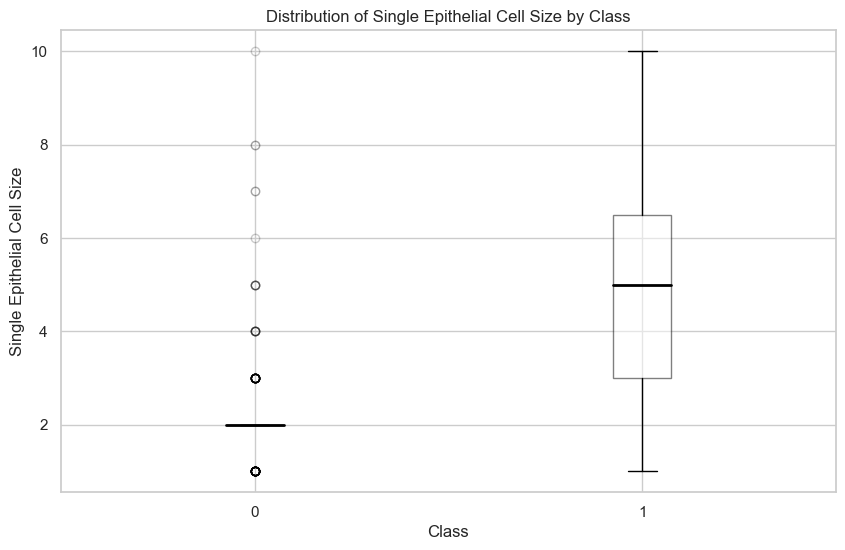

In [60]:
multiboxplot(df, "Single Epithelial Cell Size", "Class")

Looks like the Single Epithelial Cell Size is more in malignant cases. The benign samples have a few outliers with values mostly around the mean.

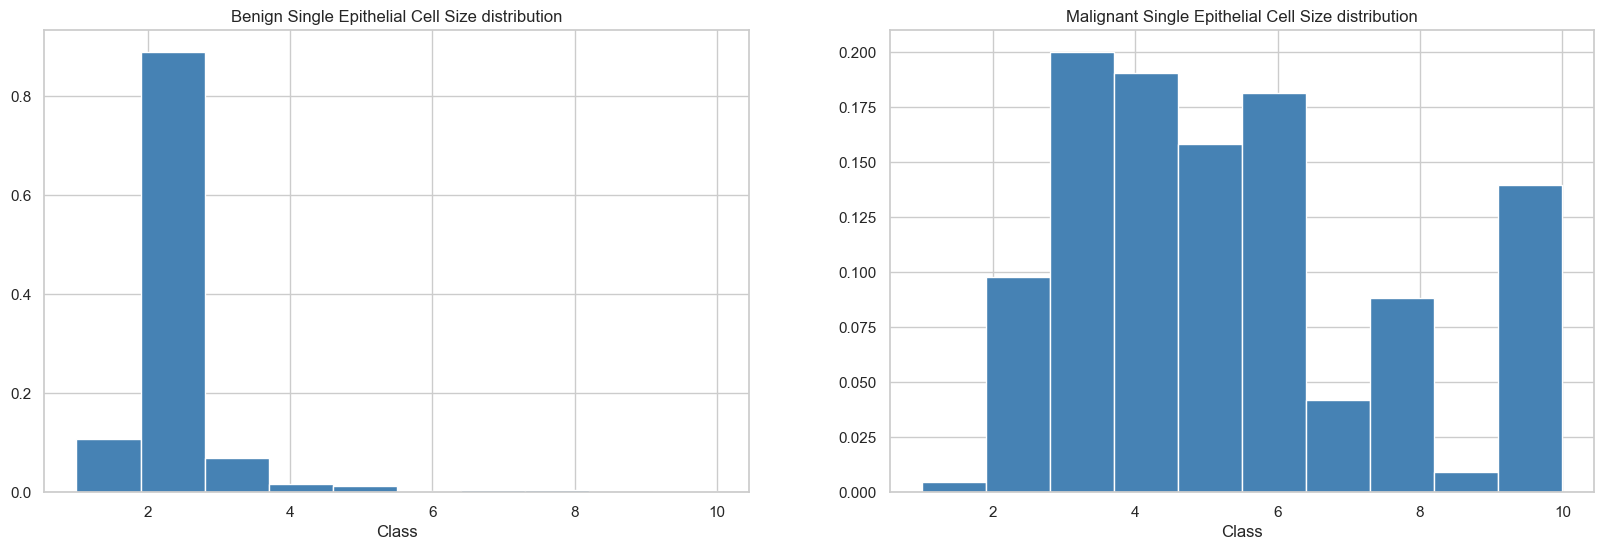

In [61]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Single Epithelial Cell Size"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Single Epithelial Cell Size distribution")
axes.set_xlabel("Class")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Single Epithelial Cell Size"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Single Epithelial Cell Size distribution")
axes.set_xlabel("Class")

plt.show()
plt.close()

As we hypothesized we see the right skewed data for benign case. Malignant samples appear to be bell shaped with more data around 5.

<a id="v_BareNuclei"></a>
## Class v. Bare Nuclei

In [62]:
ds = describe_by_category(df, "Bare Nuclei", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,1.346847,1.177848,1.0,1.0,1.0,1.0,10.0
1,239.0,7.627615,3.116679,1.0,5.0,10.0,10.0,10.0


We see there are 444 benign observations with a mean Bare Nuclei of 1.34, 239 malignant observations with mean Bare Nuclei of 7.62. We see that the samples have smaller Bare Nuclei in benign cases. In benign case the 
the mean is more than the median, therefore we sense a right skewness in the data distribution. However for malignant median is more than the mean and therefore left skewness is expected.

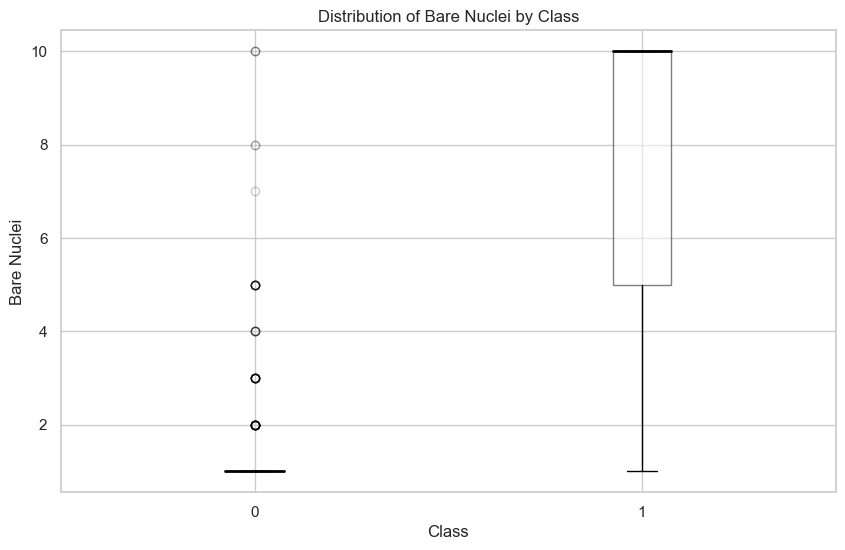

In [65]:
multiboxplot(df, "Bare Nuclei", "Class")

Looks like the Single Epithelial Cell Size is more in malignant cases. The benign samples have a few outliers with values mostly around the mean.

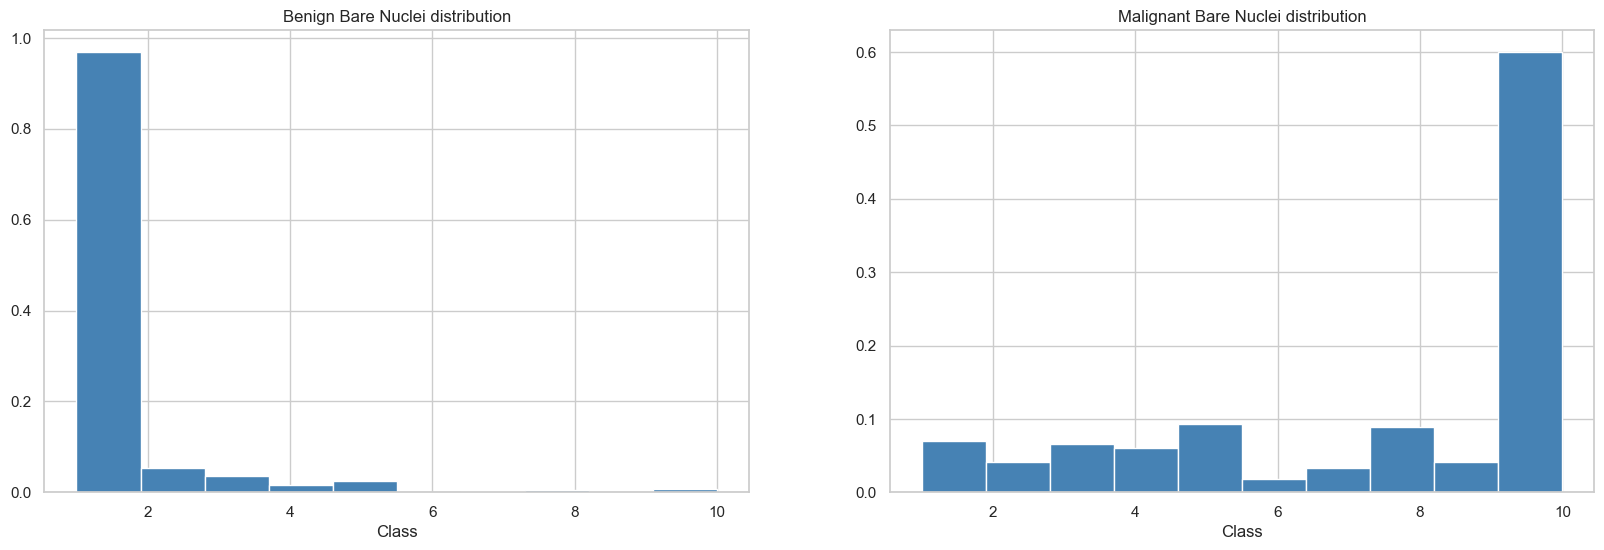

In [64]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Bare Nuclei"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Bare Nuclei distribution")
axes.set_xlabel("Class")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Bare Nuclei"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Bare Nuclei distribution")
axes.set_xlabel("Class")

plt.show()
plt.close()

As we hypothesized we see the right skewed data for benign case and left skewness in malignant. Malignant samples appear to be 
having more data around 10.

<a id="v_BlandChromatin"></a>
## Class v. Bland Chromatin

In [67]:
ds = describe_by_category(df, "Bland Chromatin", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,2.083333,1.062299,1.0,1.0,2.0,3.0,7.0
1,239.0,5.974895,2.282422,1.0,4.0,7.0,7.0,10.0


We see there are 444 benign observations with a mean Bland Chromatin of 2.08, 239 malignant observations with mean Single Epithelial Cell Size of 5.97. We see that the samples have smaller Bland Chromatin in benign cases. In benign case the the mean is more than the median, therefore we sense a right skewness in the data distribution. However for malignant median is more than the mean and therefore left skewness is expected.

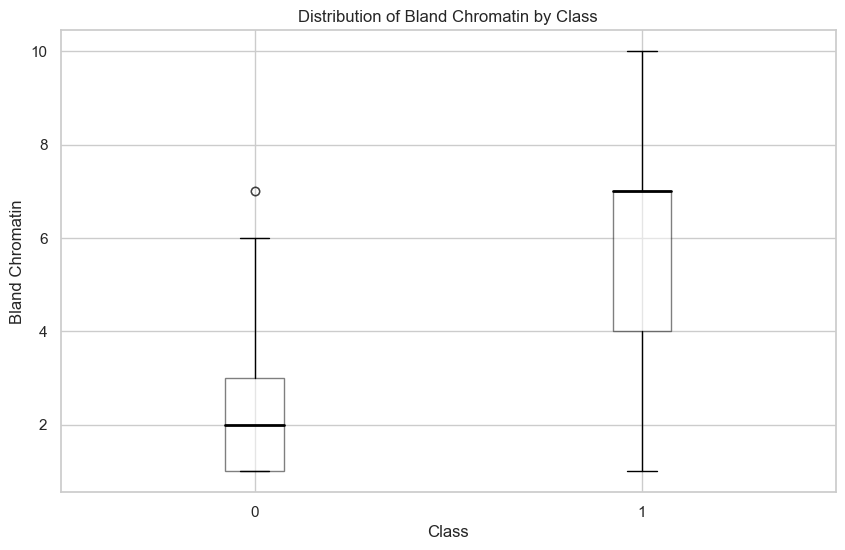

In [68]:
multiboxplot(df, "Bland Chromatin", "Class")

Looks like the Bland Chromatin is more in malignant cases. The benign samples have a few outliers with values mostly around the mean.

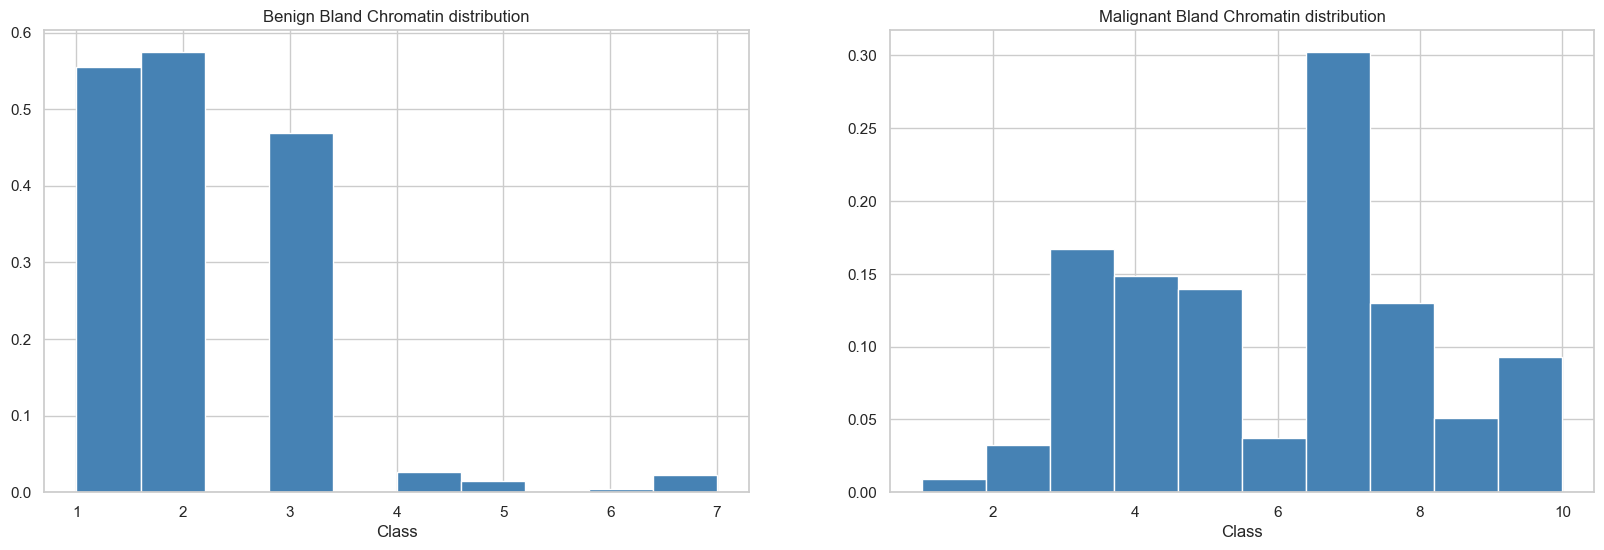

In [69]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Bland Chromatin"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Bland Chromatin distribution")
axes.set_xlabel("Class")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Bland Chromatin"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Bland Chromatin distribution")
axes.set_xlabel("Class")

plt.show()
plt.close()

As we hypothesized we see the right skewed data for benign case but with a few outliers. Malignant samples appear to be bell shaped with more data around 7.

<a id="v_NormalNucleoli"></a>
## Class v. Normal Nucleoli

In [71]:
ds = describe_by_category(df, "Normal Nucleoli", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,1.261261,0.954606,1.0,1.0,1.0,1.0,8.0
1,239.0,5.857741,3.348876,1.0,3.0,6.0,9.5,10.0


We see there are 444 benign observations with a mean Normal Nucleoli of 1.26, 239 malignant observations with mean Normal Nucleoli of 5.85. We see that the samples have smaller Normal Nucleoli in benign cases. n benign case the the mean is more than the median, therefore we sense a right skewness in the data distribution. However for malignant median is more than the mean and therefore left skewness is expected.

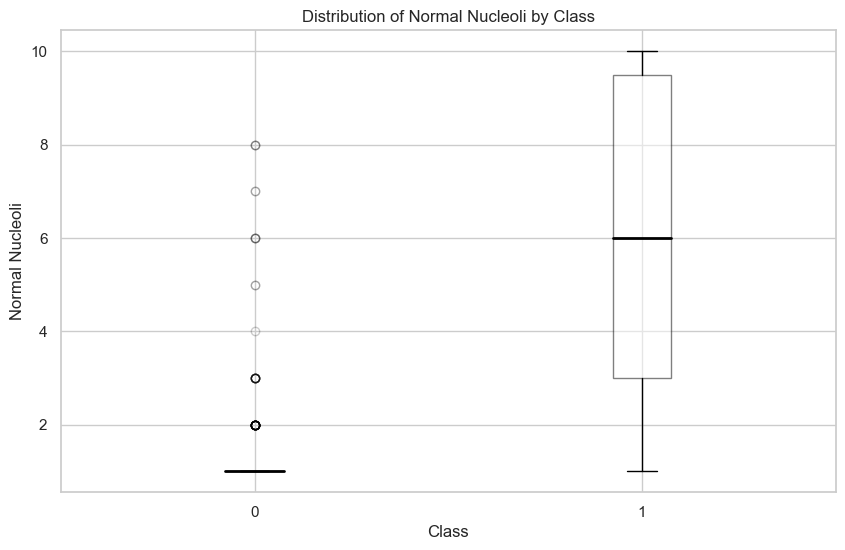

In [72]:
multiboxplot(df, "Normal Nucleoli", "Class")

Looks like the Normal Nucleoli is more in malignant cases. The benign samples have a few outliers with values mostly around the mean.

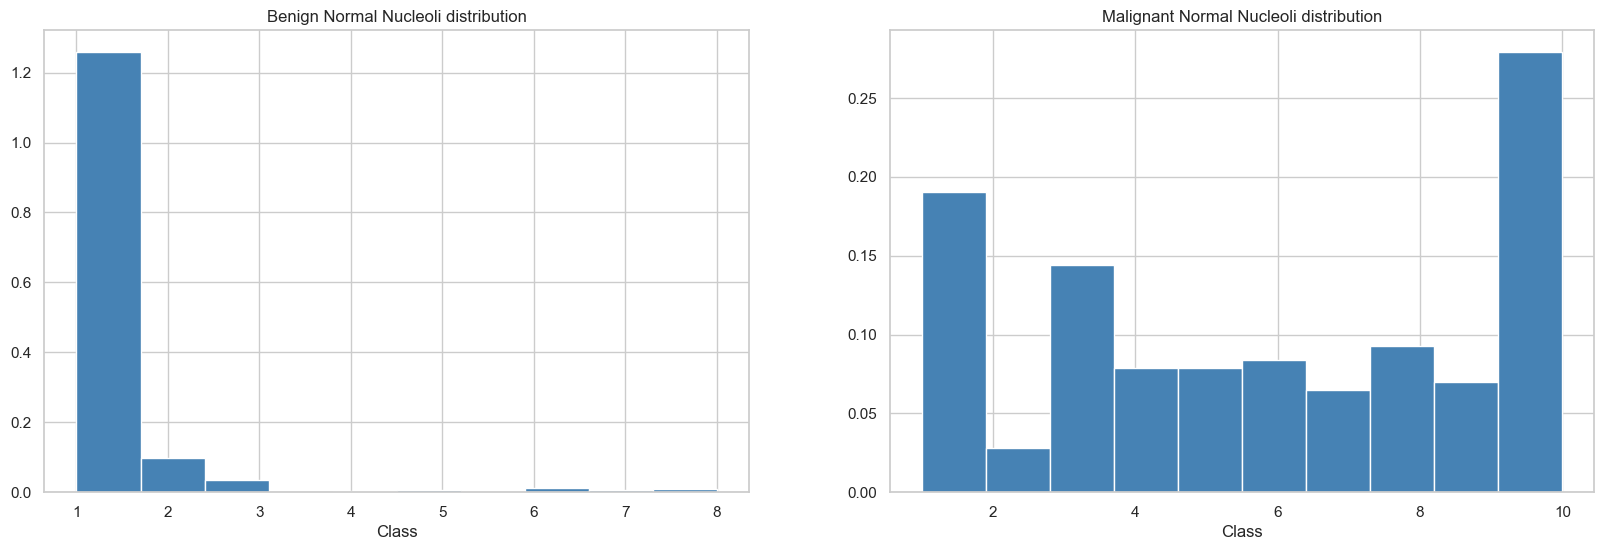

In [73]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Normal Nucleoli"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Normal Nucleoli distribution")
axes.set_xlabel("Class")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Normal Nucleoli"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Normal Nucleoli distribution")
axes.set_xlabel("Class")

plt.show()
plt.close()

As we hypothesized we see the right skewed data for benign case. Malignant samples appear to be bell shaped with more data around 10.

<a id="v_Mitoses"></a>
## Class v. Mitoses

In [74]:
ds = describe_by_category(df, "Mitoses", "Class")
pd.DataFrame(ds)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,444.0,1.065315,0.509738,1.0,1.0,1.0,1.0,8.0
1,239.0,2.602510,2.564495,1.0,1.0,1.0,3.0,10.0


We see there are 444 benign observations with a mean Single Epithelial Cell Size of 1, 239 malignant observations with mean Single Epithelial Cell Size of 2.6. We see that the samples have smaller Single Epithelial Cell Size in benign cases. Both the cases the mean is more than the median, therefore we sense a right skewness in the data distribution.

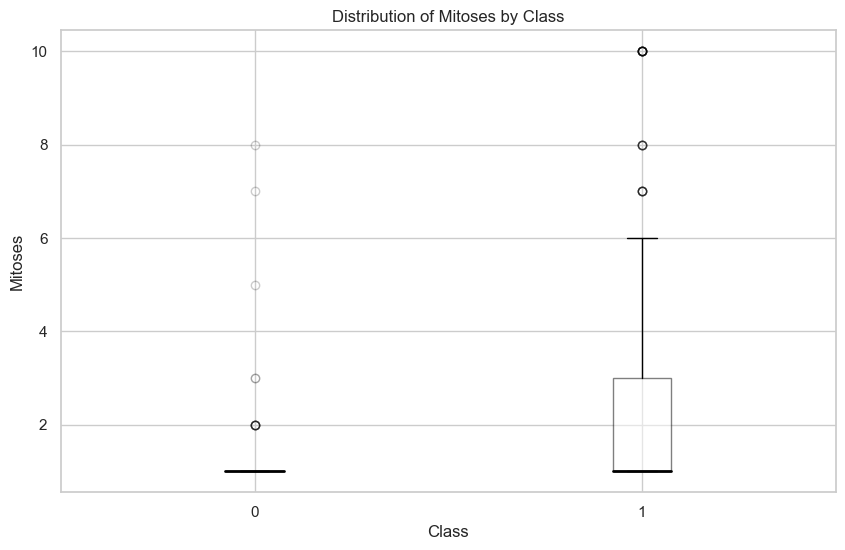

In [75]:
multiboxplot(df, "Mitoses", "Class")

Looks like the Single Epithelial Cell Size is more in malignant cases. Both samples have a few outliers with values mostly around the mean.

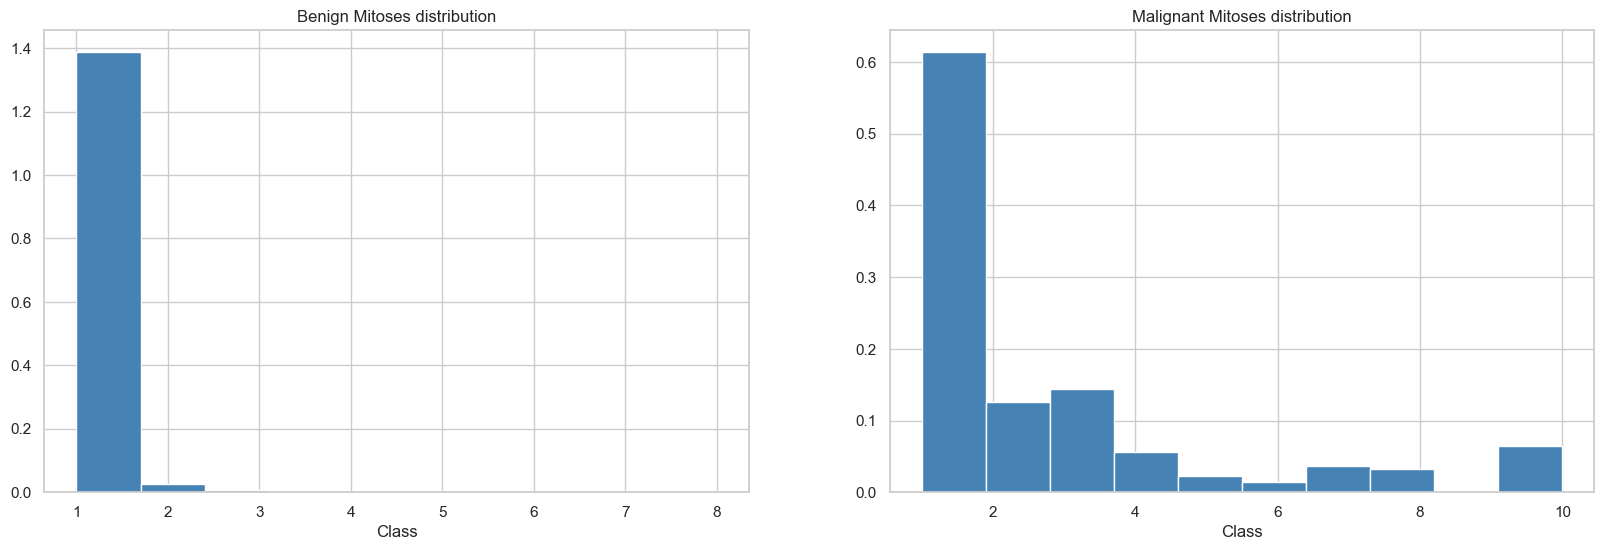

In [76]:
grouped = df.groupby("Class")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["Mitoses"].get_group(0),color=THEME,density=True)
axes.set_title("Benign Mitoses distribution")
axes.set_xlabel("Class")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["Mitoses"].get_group(1),color=THEME,density=True)
axes.set_title("Malignant Mitoses distribution")
axes.set_xlabel("Class")

plt.show()
plt.close()

As we hypothesized we see the right skewed data for benign case. Benign samples are concentrated at the mean. Malignant samples appear to be bell shaped with more data around 1.